# Data Preparation & Split Generation

## Split inventory and how the pipeline uses them

| # | Name | Main purpose | Used by training pipeline |
|---|------|--------------|---------------------------|
| **1** | Group-stratified | Leakage-safe reference split | Diagnostic/reference only |
| **2** | Balanced quota | Model selection + tuning split | **Yes (Notebook 01 primary train/val/test)** |
| **3** | Train-resampled | Rare-attack recall experiments | Optional ablation |
| **4** | Dual-eval | Balanced + realistic holdout evaluation | **Yes (Notebook 01/04 realistic generalization check)** |
| **5** | Repeated k-fold | Robustness summary across repeated folds | **Yes (metadata robustness summary)** |

Current default pipeline:
- Train/select models on *Split 2*.
- Evaluate generalization on *Split 4 `test_realistic`*.
- Use *Split 5* for fold-level robustness diagnostics.

Split 3 depends on Split 1. Run in order.



In [1]:
import os, sys, gc, json
from pathlib import Path
from hashlib import blake2b
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('Agg')  # non-interactive, avoids render memory overhead
import matplotlib.pyplot as plt

# Locate repo root and add to path
HERE = Path.cwd().resolve()
REPO_ROOT = None
for _p in [HERE] + list(HERE.parents):
    if (_p / 'ml').exists() and (_p / 'data').exists():
        REPO_ROOT = _p
        break
assert REPO_ROOT, f'Cannot find repo root from {HERE}'
os.chdir(REPO_ROOT)
sys.path.insert(0, str(REPO_ROOT))

from ml.notebooks.experiment_config import *

print('[*] Repo root        :', REPO_ROOT)
print('[*] Random seed      :', RANDOM_SEED)
print('[*] Merged parquet   :', MERGED_PARQUET)
print('[*] Zeek-only out    :', ZEEK_ONLY_PARQUET)
print('[*] Zeek+eBPF out    :', ZEEK_EBPF_PARQUET)

def mem_mb():
    try:
        import resource
        return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024
    except Exception:
        return -1

def free(*dfs):
    for df in dfs:
        del df
    gc.collect()
    print(f'[*] Memory after free: ~{mem_mb():.0f} MB')

[*] Repo root        : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel
[*] Random seed      : 42
[*] Merged parquet   : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_ebpf.parquet
[*] Zeek-only out    : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_only.parquet
[*] Zeek+eBPF out    : /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet


[*] Attack counts per day and label:
label_family   Bot  BruteForce   DDoS     DoS  Heartbleed  Infiltration  PortScan  WebAttack  TOTAL_ATTACKS
day                                                                                                        
Tuesday          0        6965      0       0           0             0         0          0           6965
Wednesday        0           0      0  190582           1             0         0          0         190583
Thursday         0           0      0       0           0            22         0       1835           1857
Friday        2208           0  86636       0           0             0    159109          0         247953


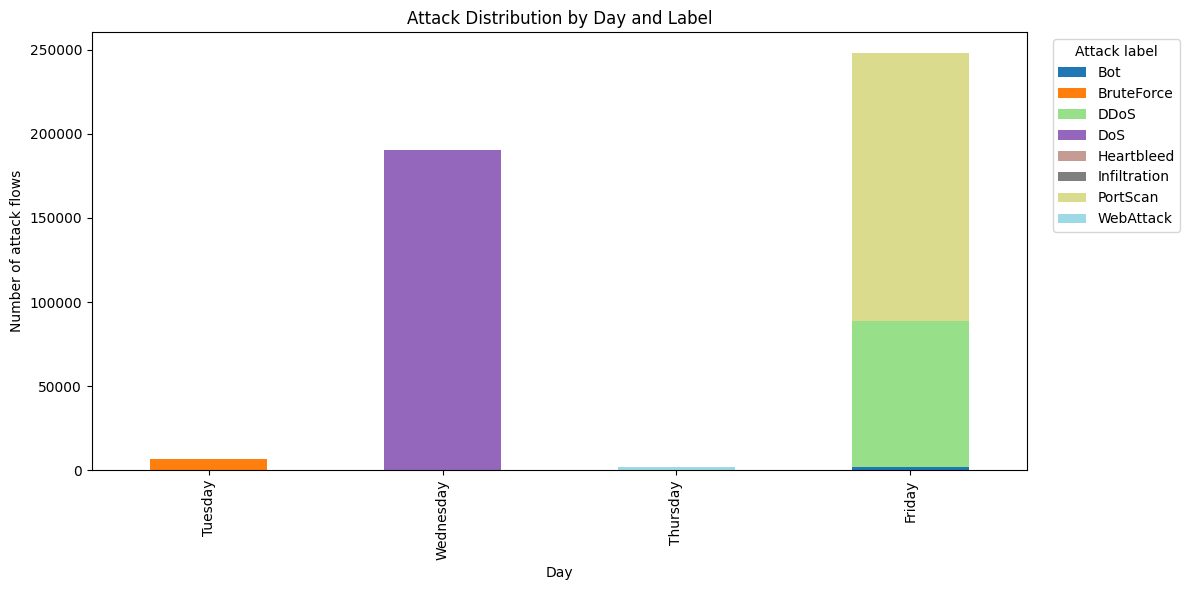

[*] Memory: ~299 MB


In [ ]:
# Attack distribution by day (top-level dataset diagnostic)
assert MERGED_PARQUET.exists(), f"Missing merged parquet: {MERGED_PARQUET}"

dist_cols = ["day", "label_family"]
df_dist = pd.read_parquet(MERGED_PARQUET, columns=dist_cols)
df_dist["day"] = df_dist["day"].astype(str)
df_dist["label_family"] = df_dist["label_family"].astype(str)

benign_like = {"BENIGN", "Unknown", "nan", "NaN", ""}
atk = df_dist[~df_dist["label_family"].isin(benign_like)].copy()

if atk.empty:
    print("[!] No attack rows found in merged dataset.")
else:
    day_label_counts = (
        atk.groupby(["day", "label_family"], dropna=False)
           .size()
           .rename("n_attacks")
           .reset_index()
    )

    pivot = (
        day_label_counts.pivot(index="day", columns="label_family", values="n_attacks")
        .fillna(0)
        .astype(int)
    )

    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    ordered_days = [d for d in day_order if d in pivot.index] + [d for d in pivot.index if d not in day_order]
    pivot = pivot.loc[ordered_days]

    pivot["TOTAL_ATTACKS"] = pivot.sum(axis=1)
    print("[*] Attack counts per day and label:")
    with pd.option_context("display.max_rows", 50, "display.max_columns", 200, "display.width", 160):
        print(pivot.to_string())

    plot_df = pivot.drop(columns=["TOTAL_ATTACKS"]).copy()
    ax = plot_df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
    ax.set_title("Attack Distribution by Day and Label")
    ax.set_xlabel("Day")
    ax.set_ylabel("Number of attack flows")
    ax.legend(title="Attack label", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

del df_dist
if 'atk' in locals():
    del atk
if 'day_label_counts' in locals():
    del day_label_counts
if 'pivot' in locals():
    del pivot
gc.collect()
print(f"[*] Memory: ~{mem_mb():.0f} MB")


## Build feature-set parquets

In [ ]:
assert MERGED_PARQUET.exists(), f'Missing merged parquet: {MERGED_PARQUET}'

if ZEEK_ONLY_PARQUET.exists() and ZEEK_EBPF_PARQUET.exists():
    print('[*] Feature-set parquets already exist, SKIPPING.')
    print(f'    {ZEEK_ONLY_PARQUET}')
    print(f'    {ZEEK_EBPF_PARQUET}')
else:
    report_dir = REPORTS_DIR / 'make_datasets'
    report_dir.mkdir(parents=True, exist_ok=True)

    # Call the function directly, no subprocess, no second Python process
    from ml.data_prep.make_datasets import main as _make_datasets_main
    _old_argv = sys.argv
    sys.argv = [
        'make_datasets',
        '--in_parquet',   str(MERGED_PARQUET),
        '--out_baseline', str(ZEEK_ONLY_PARQUET),
        '--out_enhanced', str(ZEEK_EBPF_PARQUET),
        '--report_dir',   str(report_dir),
    ]
    _make_datasets_main()
    sys.argv = _old_argv

# Sanity check, load label column only (tiny memory footprint)
for p in [ZEEK_ONLY_PARQUET, ZEEK_EBPF_PARQUET]:
    _tmp = pd.read_parquet(p, columns=['label_family'])
    print(f'[+] {p.name}: {len(_tmp):,} rows | labels: {sorted(_tmp["label_family"].unique())}')
    del _tmp
gc.collect()
print(f'[*] Memory: ~{mem_mb():.0f} MB')


[*] Wrote baseline -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_only.parquet
[*] Wrote enhanced -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet
[*] Report -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/make_datasets/make_datasets_meta.json
[+] cicids2017_multiclass_zeek_only.parquet: 2,115,236 rows | labels: ['BENIGN', 'Bot', 'BruteForce', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'PortScan', 'WebAttack']
[+] cicids2017_multiclass_zeek_plus_ebpf.parquet: 2,115,236 rows | labels: ['BENIGN', 'Bot', 'BruteForce', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'PortScan', 'WebAttack']
[*] Memory: ~862 MB


## Shared diagnostics helper

In [4]:
import pyarrow.parquet as pq

BENIGN_LIKE = {"BENIGN", "Unknown", "nan", "NaN", ""}

def _atk_count(df, lc="label_family"):
    return int((~df[lc].astype(str).isin(BENIGN_LIKE)).sum())

def _session_overlap_pct(dir_path, id_cols=("orig_h","resp_h","proto")):
    """Fraction of test (src,dst,proto) tuples that also appear in train."""
    avail = set(pq.read_schema(dir_path / "train.parquet").names)
    cols  = [c for c in id_cols if c in avail]
    if not cols:
        return None
    def _hashes(path):
        d = pd.read_parquet(path, columns=cols)
        return set(d.astype(str).apply("||".join, axis=1))
    tr = _hashes(dir_path / "train.parquet")
    te = _hashes(dir_path / "test.parquet")
    return round(len(tr & te) / max(len(te), 1) * 100, 1)

def validate_split(out_dir: Path, name: str, test_file="test.parquet") -> dict:
    """
    Load a split directory and print a quality report.
    Returns a summary dict for the final comparison table.
    """
    out_dir = Path(out_dir)
    if not (out_dir / "train.parquet").exists():
        print(f"  [!] {name}: directory not found, {out_dir}")
        return {}

    train = pd.read_parquet(out_dir / "train.parquet", columns=["label_family"])
    val   = pd.read_parquet(out_dir / "val.parquet",   columns=["label_family"]) if (out_dir/"val.parquet").exists() else None
    test  = pd.read_parquet(out_dir / test_file,       columns=["label_family"])

    total = len(train) + (len(val) if val is not None else 0) + len(test)
    tr_fams = set(train["label_family"].astype(str).unique()) - BENIGN_LIKE
    te_fams = set(test["label_family"].astype(str).unique())  - BENIGN_LIKE
    missing = sorted(tr_fams - te_fams)
    unseen  = sorted(te_fams - tr_fams)

    overlap = _session_overlap_pct(out_dir) if (out_dir/"test.parquet").exists() else None

    print(f"\n[*] {name}")
    print(f"  train : {len(train):>9,} rows  ({len(train)/total*100:.1f}%)  "
          f"attacks: {_atk_count(train):,}")
    if val is not None:
        print(f"  val   : {len(val):>9,} rows  ({len(val)/total*100:.1f}%)  "
              f"attacks: {_atk_count(val):,}")
    print(f"  test  : {len(test):>9,} rows  ({len(test)/total*100:.1f}%)  "
          f"attacks: {_atk_count(test):,}")
    if overlap is not None:
        print(f"  session overlap train intersect test: {overlap:.1f}%")

    if missing:
        print(f"  [!] families in train but NOT test: {missing}")
    if unseen:
        print(f"  [!] families in test  but NOT train (unseen): {unseen}")
    if not missing and not unseen:
        print(f"  [+] all {len(tr_fams)} attack families present in train and test")

    return {
        "name": name,
        "train_rows": len(train), "test_rows": len(test),
        "train_attacks": _atk_count(train), "test_attacks": _atk_count(test),
        "session_overlap_pct": overlap,
        "families_in_test": len(te_fams),
        "missing_from_test": missing,
        "unseen_in_test": unseen,
    }

SUMMARY = []   # filled by each section
print("[*] Diagnostics helper loaded.")


[*] Diagnostics helper loaded.


## Split 1: Group-Stratified (REFERENCE)

**Group key:** `(orig_h, resp_h)`, every flow from the same host-pair stays together.

This split is leakage-safe and useful as a reference sanity check.
Depending on class/day skew, val/test can be very sparse for some attacks.

Use for:
- Leakage diagnostics
- Reference comparisons
- Not the primary training split for the current notebook pipeline



In [5]:
from ml.data_prep.split_1_group_stratified import run as split1_run, make_report as split1_report

DIR1_BASELINE = DATASETS_DIR / f"split1_group_strat_baseline_seed{RANDOM_SEED}"
DIR1_EBPF     = DATASETS_DIR / f"split1_group_strat_ebpf_seed{RANDOM_SEED}"

def run_split1(parquet: Path, out_dir: Path, tag: str):
    if (out_dir / "train.parquet").exists():
        print(f"  [skip] {tag}, already exists. Delete {out_dir} to regenerate.")
        return

    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"  Generating Split 1, {tag} ...")

    split1_run(
        in_parquet=str(parquet),
        out_dir=str(out_dir),
        train_frac=0.70,
        val_frac=0.15,
        test_frac=0.15,
        seed=RANDOM_SEED,
    )

    print(f"[+] Written -> {out_dir}")

run_split1(ZEEK_ONLY_PARQUET, DIR1_BASELINE, "zeek_only")
run_split1(ZEEK_EBPF_PARQUET, DIR1_EBPF,     "zeek_ebpf")


  Generating Split 1, zeek_only ...
[*] Pass 1/2: building group table (streaming)...
[*] Pass 2/2: writing train/val/test (streaming)...
[*] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split1_group_strat_baseline_seed42
[+] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split1_group_strat_baseline_seed42
  Generating Split 1, zeek_ebpf ...
[*] Pass 1/2: building group table (streaming)...
[*] Pass 2/2: writing train/val/test (streaming)...
[*] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split1_group_strat_ebpf_seed42
[+] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split1_group_strat_ebpf_seed42


In [6]:
row = validate_split(DIR1_BASELINE, "Split 1, group_stratified (zeek_only)")
SUMMARY.append(row)



[*] Split 1, group_stratified (zeek_only)
  train : 1,617,391 rows  (76.5%)  attacks: 446,439
  val   :   249,217 rows  (11.8%)  attacks: 558
  test  :   248,628 rows  (11.8%)  attacks: 361
  session overlap train intersect test: 0.0%
  [!] families in train but NOT test: ['BruteForce', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'PortScan', 'WebAttack']


## Split 2: Balanced Quota (PRIMARY TRAINING SPLIT)

Downsamples each attack family to `quota` rows, caps BENIGN at
`benign_ratio x total_attack_rows`, then splits 70/15/15.

Why this is primary for model training/selection:
- Better class coverage in train/val/test
- Stable model ranking across families
- Suitable for tuning and overfitting control

In [7]:
import json
import shutil

from ml.data_prep.split_2_balanced_quota import run as split2_run

DIR2_BASELINE = DATASETS_DIR / f"split2_balanced_quota_baseline_seed{RANDOM_SEED}"
DIR2_EBPF     = DATASETS_DIR / f"split2_balanced_quota_ebpf_seed{RANDOM_SEED}"

QUOTA = 5_000  # cap per attack family; Heartbleed/Infiltration will be smaller


def _valid_split2_dir(out_dir: Path) -> bool:
    required = ["train.parquet", "val.parquet", "test.parquet", "split_report.json"]
    try:
        for name in required:
            fp = out_dir / name
            if not fp.exists() or fp.stat().st_size < 16:
                return False
        pd.read_parquet(out_dir / "train.parquet", columns=["label_family"]).head(1)
        pd.read_parquet(out_dir / "test.parquet", columns=["label_family"]).head(1)
        json.loads((out_dir / "split_report.json").read_text())
        return True
    except Exception:
        return False


def run_split2(parquet: Path, out_dir: Path, tag: str):
    if _valid_split2_dir(out_dir):
        print(f"  [skip] {tag}, already exists and valid.")
        return

    if out_dir.exists():
        print(f"  [*] {tag}, found stale/incomplete output. Regenerating {out_dir}.")
        shutil.rmtree(out_dir)

    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"  Generating Split 2, {tag} ...")

    # split2_run writes artifacts and returns the output path.
    split2_run(
        in_parquet=str(parquet),
        out_dir=str(out_dir),
        quota=QUOTA,
        benign_ratio=1.0,
        equal=False,
        seed=RANDOM_SEED,
        batch_size=131072,
    )

    train_df = pd.read_parquet(out_dir / "train.parquet", columns=["label_family"])
    val_df   = pd.read_parquet(out_dir / "val.parquet", columns=["label_family"])
    test_df  = pd.read_parquet(out_dir / "test.parquet", columns=["label_family"])

    print(f"[+] Written -> {out_dir}")
    print(f"  - rows: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
    print(
        "  - classes(train/val/test): "
        f"{train_df['label_family'].nunique()}/{val_df['label_family'].nunique()}/{test_df['label_family'].nunique()}"
    )

run_split2(ZEEK_ONLY_PARQUET, DIR2_BASELINE, "zeek_only")
run_split2(ZEEK_EBPF_PARQUET, DIR2_EBPF,     "zeek_ebpf")


  Generating Split 2, zeek_only ...
  Mode              : capped (each class up to quota)
  Requested quota   : 5,000
  BENIGN ratio      : 1.0x  (benign = ratio x total_attack_rows)

    Bot                     have=  2,208  take= 2,208 <- ALL
    BruteForce              have=  6,965  take= 5,000
    DDoS                    have= 86,636  take= 5,000
    DoS                     have=190,582  take= 5,000
    Heartbleed              have=      1  take=     1 <- ALL
    Infiltration            have=     22  take=    22 <- ALL
    PortScan                have=159,109  take= 5,000
    WebAttack               have=  1,835  take= 1,835 <- ALL
    BENIGN                  have=1,667,878  take=24,066  (ratio 1.0x)
[+] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split2_balanced_quota_baseline_seed42
  - rows: train=33692, val=7220, test=7220
  - classes(train/val/test): 8/9/8
  Generating Split 2, zeek_ebpf ...
  Mode              : capped (each class up to quot

In [8]:
row = validate_split(DIR2_BASELINE, "Split 2, balanced_quota (zeek_only)")
SUMMARY.append(row)



[*] Split 2, balanced_quota (zeek_only)
  train :    33,692 rows  (70.0%)  attacks: 16,850
  val   :     7,220 rows  (15.0%)  attacks: 3,619
  test  :     7,220 rows  (15.0%)  attacks: 3,597
  session overlap train intersect test: 34.9%
  [+] all 7 attack families present in train and test


## Split 3: Train-Only Resampled (IMPROVED LEARNING)

Takes the Split 1 output and rebalances **only the training set**.
`val` and `test` are passed through identical to Split 1, evaluation is unchanged.

- Minority attack families oversampled to `target_n` rows (random duplication)
- BENIGN downsampled to `benign_ratio` x total attack rows in train
- Evaluation remains honest and realistic (same test set as Split 1)

Use for: comparing model recall on rare classes (Heartbleed, Infiltration) with
and without rebalancing. "Resampling train improved Heartbleed recall from X to Y
with no change to test distribution."

**Requires Split 1**.

In [ ]:
import json
import shutil

from ml.data_prep.split_3_train_resampled import run as split3_run

DIR3_BASELINE = DATASETS_DIR / f"split3_train_resampled_baseline_seed{RANDOM_SEED}"
DIR3_EBPF     = DATASETS_DIR / f"split3_train_resampled_ebpf_seed{RANDOM_SEED}"
TARGET_N      = 5_000   # target rows per attack family in resampled train


def _valid_split3_dir(out_dir: Path) -> bool:
    required = ["train.parquet", "val.parquet", "test.parquet", "split_report.json"]
    try:
        for name in required:
            fp = out_dir / name
            if not fp.exists() or fp.stat().st_size < 16:
                return False
        pd.read_parquet(out_dir / "train.parquet", columns=["label_family"]).head(1)
        pd.read_parquet(out_dir / "test.parquet", columns=["label_family"]).head(1)
        json.loads((out_dir / "split_report.json").read_text())
        return True
    except Exception:
        return False


def run_split3(split1_dir: Path, out_dir: Path, tag: str):
    if _valid_split3_dir(out_dir):
        print(f"  [skip] {tag}, already exists and valid.")
        return

    if not (split1_dir / "train.parquet").exists():
        print(f"  [!] Split 1 not found at {split1_dir}, run Split 1 first.")
        return

    if out_dir.exists():
        print(f"  [*] {tag}, found stale/incomplete output. Regenerating {out_dir}.")
        shutil.rmtree(out_dir)

    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"  Generating Split 3, {tag} ...")

    result = split3_run(
        split1_dir=split1_dir,
        out_dir=str(out_dir),
        target_n=TARGET_N,
        benign_ratio=3.0,
        seed=RANDOM_SEED,
    )

    for s in ["train", "val", "test"]:
        result[s].to_parquet(out_dir / f"{s}.parquet", index=False)

    (out_dir / "split_report.json").write_text(json.dumps(result["meta"], indent=2))

    free(*[result[s] for s in ["train", "val", "test"]])

    print(f"[+] Written -> {out_dir}")


run_split3(DIR1_BASELINE, DIR3_BASELINE, "zeek_only")
run_split3(DIR1_EBPF,     DIR3_EBPF,     "zeek_ebpf")


  Generating Split 3, zeek_only ...
  target_n per family : 5,000
  benign_ratio        : 3.0x

  Family resampling:
    Bot                      1,310 ->  5,000  up oversample
    BruteForce               6,965 ->  5,000  down downsample
    DDoS                    86,636 ->  5,000  down downsample
    DoS                     190,582 ->  5,000  down downsample
    Heartbleed                   1 ->  5,000  up oversample
    Infiltration                 1 ->  5,000  up oversample
    PortScan                159,109 ->  5,000  down downsample
    WebAttack                1,835 ->  5,000  up oversample
    BENIGN                  1,170,952 -> 120,000  reservoir(sample)
[*] Memory after free: ~1547 MB
[+] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split3_train_resampled_baseline_seed42
  Generating Split 3, zeek_ebpf ...
  target_n per family : 5,000
  benign_ratio        : 3.0x

  Family resampling:
    Bot                      1,310 ->  5,000  up overs

In [10]:
row = validate_split(DIR3_BASELINE, "Split 3, train_resampled (zeek_only)")
SUMMARY.append(row)



[*] Split 3, train_resampled (zeek_only)
  train :   160,000 rows  (24.3%)  attacks: 40,000
  val   :   249,217 rows  (37.9%)  attacks: 558
  test  :   248,628 rows  (37.8%)  attacks: 361
  session overlap train intersect test: 0.0%
  [!] families in train but NOT test: ['BruteForce', 'DDoS', 'DoS', 'Heartbleed', 'Infiltration', 'PortScan', 'WebAttack']


## Split 4: Dual Evaluation (GENERALIZATION CHECK)

Produces two test sets from the same training set:

| File | Contents | Use for |
|------|----------|---------|
| `test_balanced.parquet` | Equal samples per family | Fair class-level comparison |
| `test_realistic.parquet` | Friday flows, untouched | Distribution-shift generalization |

In [ ]:
import json
import shutil

from ml.data_prep.split_4_dual_eval import run as split4_run

DIR4_BASELINE = DATASETS_DIR / f"split4_dual_eval_baseline_seed{RANDOM_SEED}"
DIR4_EBPF     = DATASETS_DIR / f"split4_dual_eval_ebpf_seed{RANDOM_SEED}"


def _valid_split4_dir(out_dir: Path) -> bool:
    required = [
        "train.parquet",
        "val.parquet",
        "test_balanced.parquet",
        "test_realistic.parquet",
        "split_report.json",
    ]
    try:
        for name in required:
            fp = out_dir / name
            if not fp.exists() or fp.stat().st_size < 16:
                return False
        # quick read check to catch truncated parquet files
        pd.read_parquet(out_dir / "train.parquet", columns=["label_family"]).head(1)
        pd.read_parquet(out_dir / "test_balanced.parquet", columns=["label_family"]).head(1)
        pd.read_parquet(out_dir / "test_realistic.parquet", columns=["label_family"]).head(1)
        json.loads((out_dir / "split_report.json").read_text())
        return True
    except Exception:
        return False


def run_split4(parquet: Path, out_dir: Path, tag: str):
    if _valid_split4_dir(out_dir):
        print(f"  [skip] {tag}, already exists and valid.")
        return

    if out_dir.exists():
        print(f"  [*] {tag}, found stale/incomplete output. Regenerating {out_dir}.")
        shutil.rmtree(out_dir)

    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"  Generating Split 4, {tag} ...")

    result = split4_run(
        in_parquet=str(parquet),
        out_dir=str(out_dir),
        quota=500,
        benign_ratio=1.0,
        seed=RANDOM_SEED,
    )

    # Persist again explicitly for notebook reproducibility
    for s in ["train", "val", "test_balanced", "test_realistic"]:
        result[s].to_parquet(out_dir / f"{s}.parquet", index=False)

    (out_dir / "split_report.json").write_text(json.dumps(result["meta"], indent=2))

    free(*[result[s] for s in ["train", "val", "test_balanced", "test_realistic"]])
    print(f"[+] Written -> {out_dir}")


run_split4(ZEEK_ONLY_PARQUET, DIR4_BASELINE, "zeek_only")
run_split4(ZEEK_EBPF_PARQUET, DIR4_EBPF,     "zeek_ebpf")


  Generating Split 4, zeek_only ...
  Balanced test quota : 500 -> effective: 1 (bottleneck: Heartbleed=1)
  BENIGN in balanced  : 8 (ratio 1.0x)

[*] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split4_dual_eval_baseline_seed42
[*] Memory after free: ~2105 MB
[+] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split4_dual_eval_baseline_seed42
  Generating Split 4, zeek_ebpf ...
  Balanced test quota : 500 -> effective: 1 (bottleneck: Heartbleed=1)
  BENIGN in balanced  : 8 (ratio 1.0x)

[*] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split4_dual_eval_ebpf_seed42
[*] Memory after free: ~2448 MB
[+] Written -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split4_dual_eval_ebpf_seed42


In [12]:
# Validate both test sets for Split 4
out4 = Path(DIR4_BASELINE)
if (out4 / "train.parquet").exists():
    print("  Balanced test:")
    row_b = validate_split(out4, "Split 4, dual_eval balanced (zeek_only)",
                           test_file="test_balanced.parquet")
    print("\n  Realistic test (Friday holdout):")
    row_r = validate_split(out4, "Split 4, dual_eval realistic (zeek_only)",
                           test_file="test_realistic.parquet")
    SUMMARY.append(row_b)
    SUMMARY.append(row_r)
else:
    print("  [!] Split 4 not generated yet.")


  Balanced test:

[*] Split 4, dual_eval balanced (zeek_only)
  train : 1,205,997 rows  (76.9%)  attacks: 197,545
  val   :   363,024 rows  (23.1%)  attacks: 1,857
  test  :        16 rows  (0.0%)  attacks: 8
  [!] families in test  but NOT train (unseen): ['Bot', 'DDoS', 'Heartbleed', 'Infiltration', 'PortScan', 'WebAttack']

  Realistic test (Friday holdout):

[*] Split 4, dual_eval realistic (zeek_only)
  train : 1,205,997 rows  (57.0%)  attacks: 197,545
  val   :   363,024 rows  (17.2%)  attacks: 1,857
  test  :   546,207 rows  (25.8%)  attacks: 247,953
  [!] families in train but NOT test: ['BruteForce', 'DoS']
  [!] families in test  but NOT train (unseen): ['Bot', 'DDoS', 'PortScan']


## Split 5: Repeated K-Fold (ROBUSTNESS)

Repeated folds are used for robustness diagnostics.
In this repo we store/report fold metadata (rows, attacks, unseen families)
without materializing all fold train/test datasets in-memory.

Use for:
- Stability diagnostics across folds
- Mean/range reporting for fold composition



In [ ]:
import json
import shutil

from ml.data_prep.split_5_kfold import run_metadata_streaming as split5_run

DIR5_BASELINE = DATASETS_DIR / f"split5_kfold_baseline_seed{RANDOM_SEED}"
DIR5_EBPF     = DATASETS_DIR / f"split5_kfold_ebpf_seed{RANDOM_SEED}"


def _valid_split5_dir(out_dir: Path) -> bool:
    rp = out_dir / "kfold_report.json"
    if not rp.exists() or rp.stat().st_size < 16:
        return False
    try:
        rep = json.loads(rp.read_text())
        return "total_folds" in rep and "folds" in rep and len(rep["folds"]) > 0
    except Exception:
        return False


def run_split5(parquet: Path, out_dir: Path, tag: str):
    if _valid_split5_dir(out_dir):
        print(f"  [skip] {tag}, already exists and valid.")
        return

    if out_dir.exists():
        print(f"  [*] {tag}, found stale/incomplete output. Regenerating {out_dir}.")
        shutil.rmtree(out_dir)

    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"  Generating Split 5 metadata-only, {tag} ...")

    result = split5_run(
        in_parquet=str(parquet),
        out_dir=str(out_dir),
        n_splits=5,
        n_repeats=3,
        seed=RANDOM_SEED,
        batch_size=131072,
    )

    (out_dir / "kfold_report.json").write_text(json.dumps(result["meta"], indent=2))
    print(f"  [+] Written {result['meta']['total_folds']} fold summaries -> {out_dir}")


run_split5(ZEEK_ONLY_PARQUET, DIR5_BASELINE, "zeek_only")
run_split5(ZEEK_EBPF_PARQUET, DIR5_EBPF,     "zeek_ebpf")


  Generating Split 5 metadata-only, zeek_only ...
[*] Building group table (streaming)...
[!] Smallest dominant-label group count is 1; falling back to repeated shuffled KFold (non-stratified).
  Counting fold_00_rep0...
  Counting fold_01_rep0...
  Counting fold_02_rep0...
  Counting fold_03_rep0...
  Counting fold_04_rep0...
  Counting fold_00_rep1...
  Counting fold_01_rep1...
  Counting fold_02_rep1...
  Counting fold_03_rep1...
  Counting fold_04_rep1...
  Counting fold_00_rep2...
  Counting fold_01_rep2...
  Counting fold_02_rep2...
  Counting fold_03_rep2...
  Counting fold_04_rep2...
  [+] Written 15 fold summaries -> /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/datasets/split5_kfold_baseline_seed42
  Generating Split 5 metadata-only, zeek_ebpf ...
[*] Building group table (streaming)...
[!] Smallest dominant-label group count is 1; falling back to repeated shuffled KFold (non-stratified).
  Counting fold_00_rep0...
  Counting fold_01_rep0...
  Counting fold_02_re

In [14]:
# Quick k-fold summary (reads kfold_report.json, no parquet loading needed)
import json as _json
rep_path = Path(DIR5_BASELINE) / "kfold_report.json"
if rep_path.exists():
    rep = _json.loads(rep_path.read_text())
    folds = rep["folds"]
    tr_rows = [f["train_rows"]    for f in folds]
    te_rows = [f["test_rows"]     for f in folds]
    te_atk  = [f["test_attacks"]  for f in folds]
    print(f"  Split 5, {rep['total_folds']} folds  "
          f"(n_splits={rep['n_splits']}, n_repeats={rep['n_repeats']})")
    print(f"  train rows : mean={sum(tr_rows)/len(tr_rows):,.0f}  "
          f"min={min(tr_rows):,}  max={max(tr_rows):,}")
    print(f"  test  rows : mean={sum(te_rows)/len(te_rows):,.0f}  "
          f"min={min(te_rows):,}  max={max(te_rows):,}")
    print(f"  test attacks: mean={sum(te_atk)/len(te_atk):,.0f}  "
          f"min={min(te_atk):,}")
    unseen_any = [f for f in folds if f["unseen_in_train"]]
    if unseen_any:
        print(f"  [!] {len(unseen_any)} folds have unseen-in-train families:")
        for f in unseen_any:
            print(f"      {f['fold']}: {f['unseen_in_train']}")
    else:
        print(f"  [+] All attack families present in train for every fold")
    SUMMARY.append({"name":"Split 5, kfold","note":f"{rep['total_folds']} folds, see kfold_report.json"})
else:
    print("  [!] Split 5 not generated yet.")


  Split 5, 15 folds  (n_splits=5, n_repeats=3)
  train rows : mean=1,692,189  min=1,197,254  max=1,884,738
  test  rows : mean=423,047  min=230,498  max=917,982
  test attacks: mean=89,472  min=0
  [!] 9 folds have unseen-in-train families:
      fold_01_rep0: ['PortScan']
      fold_02_rep0: ['DoS', 'Heartbleed']
      fold_03_rep0: ['Infiltration']
      fold_02_rep1: ['PortScan']
      fold_03_rep1: ['Heartbleed']
      fold_04_rep1: ['DoS', 'Infiltration']
      fold_00_rep2: ['Infiltration']
      fold_03_rep2: ['Heartbleed']
      fold_04_rep2: ['DoS', 'PortScan']


## Summary comparison table


In [ ]:
df_sum = pd.DataFrame([r for r in SUMMARY if r.get("train_rows")])
if not df_sum.empty:
    cols = ["name","train_rows","test_rows","train_attacks","test_attacks",
            "session_overlap_pct","families_in_test"]
    cols = [c for c in cols if c in df_sum.columns]
    with pd.option_context("display.max_colwidth", 40, "display.width", 120):
        print(df_sum[cols].to_string(index=False))
print()
print("Recommended usage (current notebooks 01-04):")
print("  1. Split 2  -> train/val/test for model selection and tuning")
print("  2. Split 4  -> realistic generalization check (test_realistic)")
print("  3. Split 5  -> robustness diagnostics (fold metadata summary)")
print("  4. Split 3  -> optional rare-attack recall experiments")
print("  5. Split 1  -> leakage-safe reference/diagnostic split")


                                    name  train_rows  test_rows  train_attacks  test_attacks  session_overlap_pct  families_in_test
   Split 1, group_stratified (zeek_only)     1617391     248628         446439           361                  0.0                 1
     Split 2, balanced_quota (zeek_only)       33692       7220          16850          3597                 34.9                 7
    Split 3, train_resampled (zeek_only)      160000     248628          40000           361                  0.0                 1
 Split 4, dual_eval balanced (zeek_only)     1205997         16         197545             8                  NaN                 8
Split 4, dual_eval realistic (zeek_only)     1205997     546207         197545        247953                  NaN                 3

Recommended usage (current notebooks 01-04):
  1. Split 2  -> train/val/test for model selection and tuning
  2. Split 4  -> realistic generalization check (test_realistic)
  3. Split 5  -> robustness diagno

## Label distribution plots


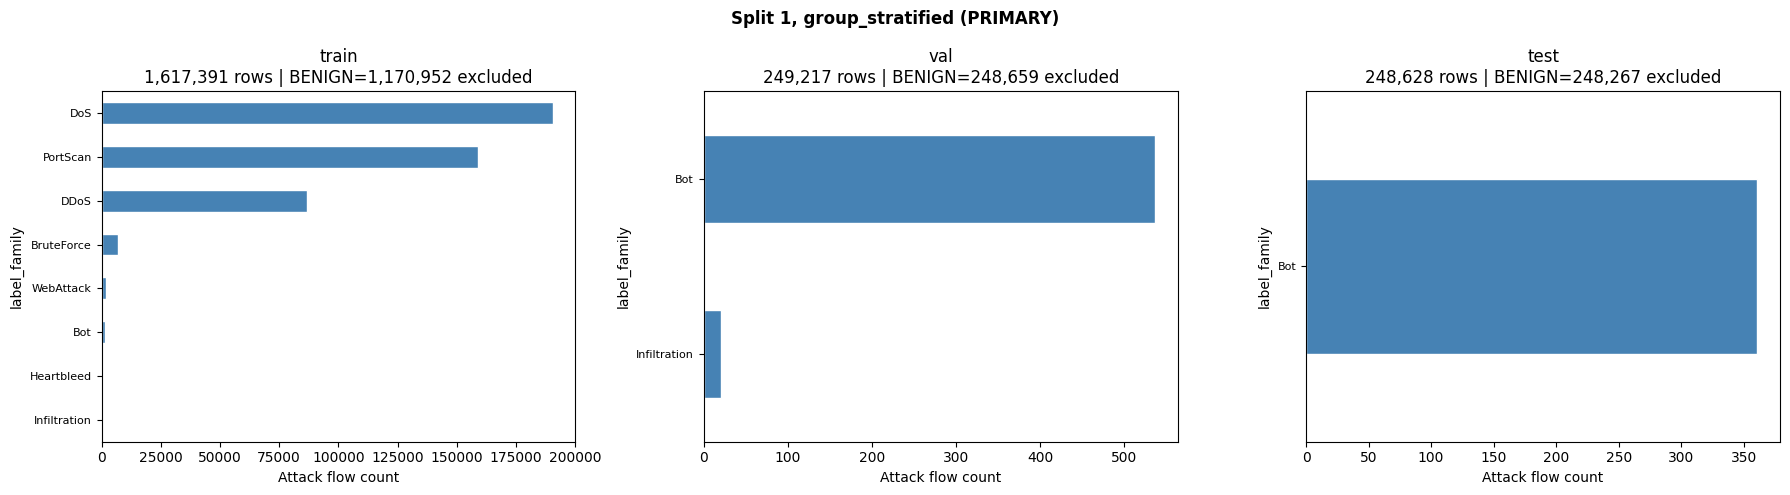

  Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_Split_1__group_stratified__PRIMARY_.png


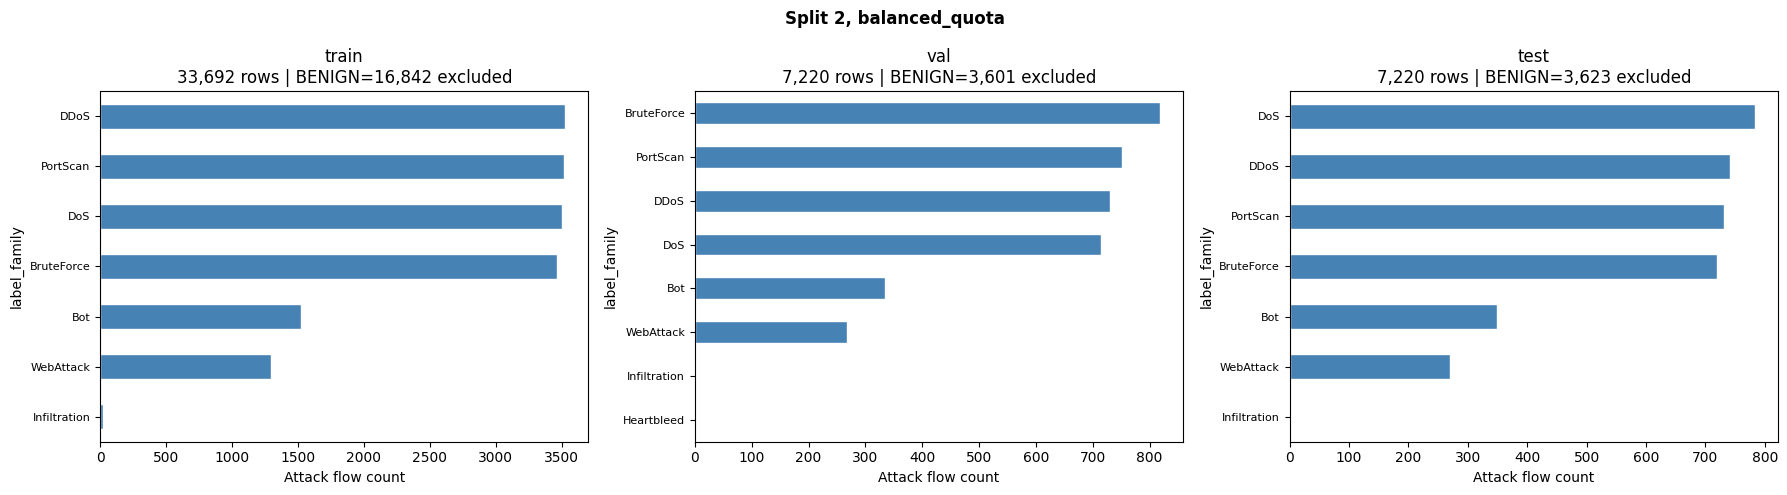

  Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_Split_2__balanced_quota.png


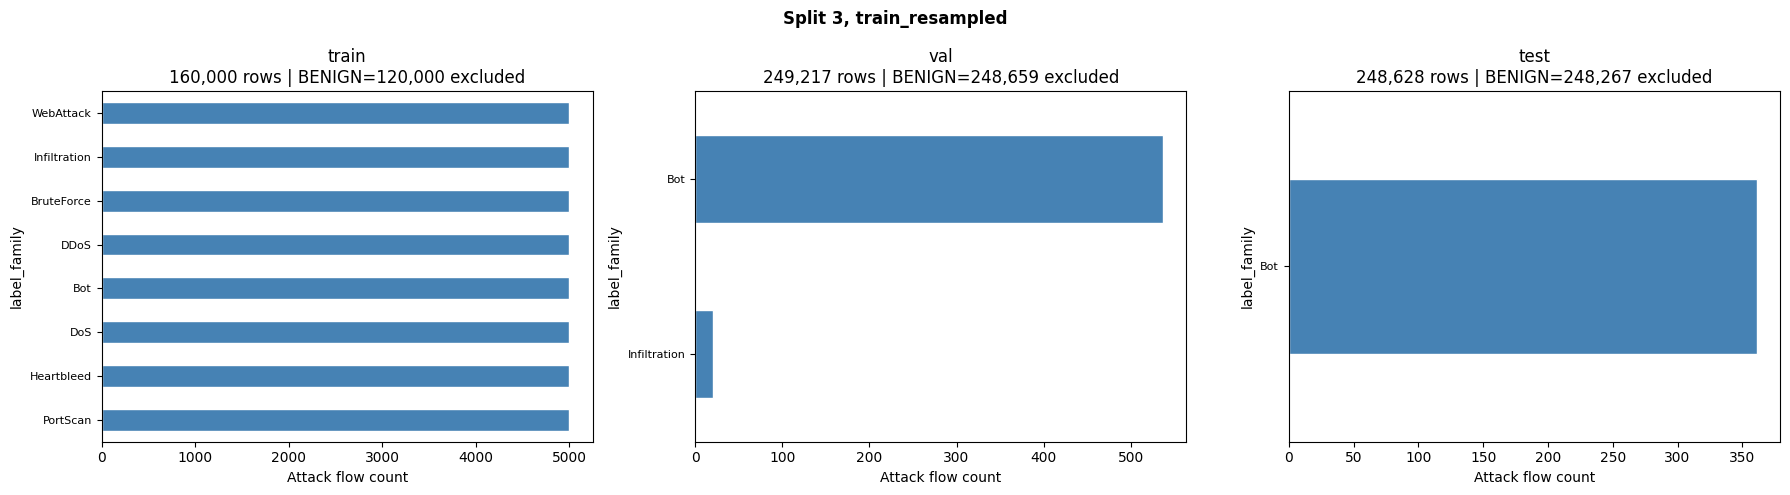

  Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_Split_3__train_resampled.png


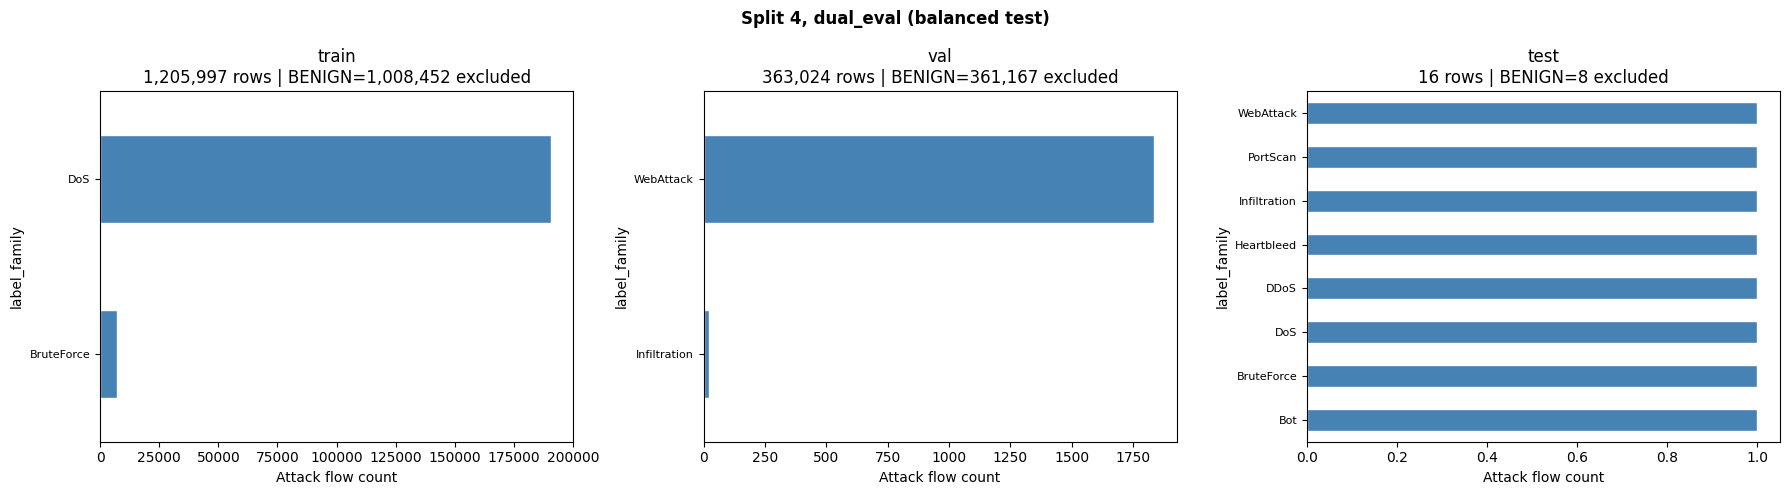

  Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_Split_4__dual_eval__balanced_test_.png


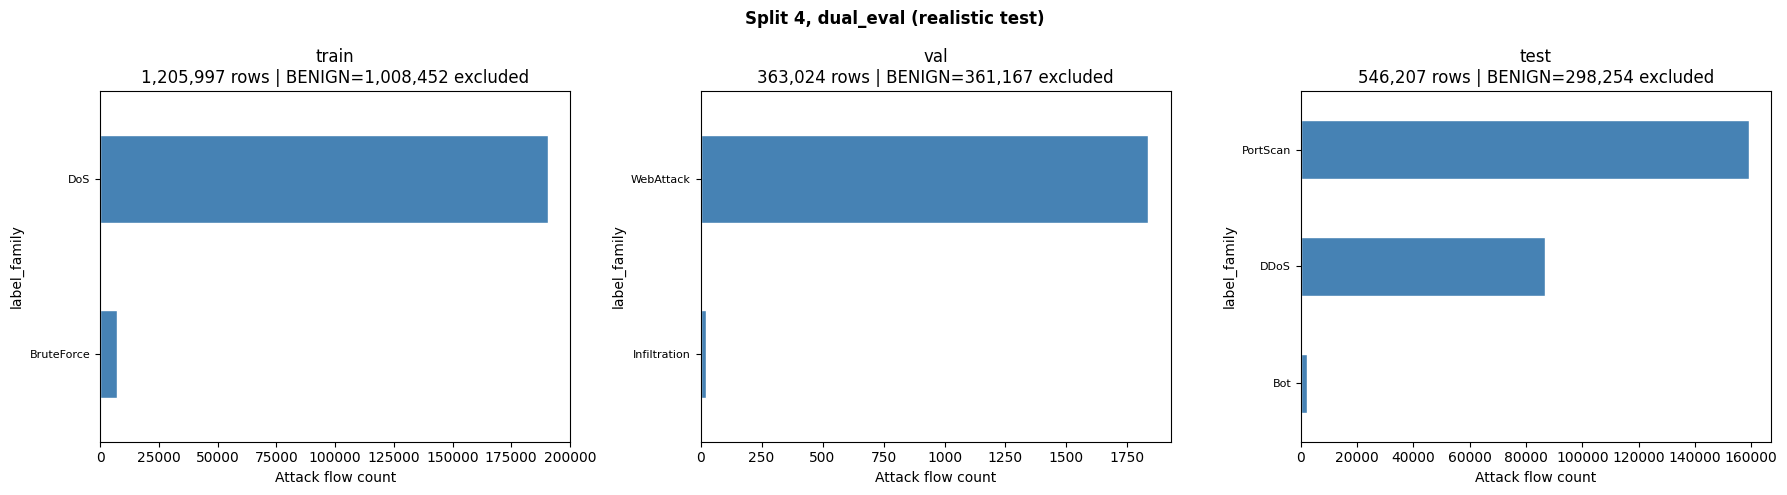

  Saved: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports/label_dist_Split_4__dual_eval__realistic_test_.png


In [16]:
def plot_dist(splits_dir: Path, title: str, test_file="test.parquet"):
    splits_dir = Path(splits_dir)
    files = {"train": "train.parquet", "val": "val.parquet", "test": test_file}
    existing = {k: v for k, v in files.items() if (splits_dir / v).exists()}
    if "train" not in existing:
        print(f"  [skip] {title}: not found")
        return

    n = len(existing)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1: axes = [axes]
    for ax, (split, fname) in zip(axes, existing.items()):
        df     = pd.read_parquet(splits_dir / fname, columns=["label_family"])
        total  = len(df)
        benign = int((df["label_family"] == "BENIGN").sum())
        vc     = df["label_family"].value_counts().drop("BENIGN", errors="ignore")
        del df
        if vc.empty:
            ax.text(0.5, 0.5, "No attack flows", ha="center", va="center",
                    transform=ax.transAxes, color="grey")
        else:
            vc.sort_values().plot(kind="barh", ax=ax, color="steelblue", edgecolor="white")
        ax.set_title(f"{split}\n{total:,} rows | BENIGN={benign:,} excluded")
        ax.set_xlabel("Attack flow count")
        ax.tick_params(axis="y", labelsize=8)
    gc.collect()
    fig.suptitle(title, fontsize=12, fontweight="bold")
    plt.tight_layout()
    safe = "".join(c if c.isalnum() or c in "-_" else "_" for c in title)
    out  = REPORTS_DIR / f"label_dist_{safe}.png"
    plt.savefig(out, dpi=120, bbox_inches="tight")
    plt.show(); plt.close(fig)
    print(f"  Saved: {out}")

plot_dist(DIR1_BASELINE, "Split 1, group_stratified (PRIMARY)")
plot_dist(DIR2_BASELINE, "Split 2, balanced_quota")
plot_dist(DIR3_BASELINE, "Split 3, train_resampled")
plot_dist(DIR4_BASELINE, "Split 4, dual_eval (balanced test)", test_file="test_balanced.parquet")
plot_dist(DIR4_BASELINE, "Split 4, dual_eval (realistic test)", test_file="test_realistic.parquet")
